# 基于ViLD的开放世界室内物体检测

本项目实现了基于Vision-Language知识蒸馏(ViLD)的开放世界室内物体检测系统。主要特点：

1. 使用RTDETR作为基础检测器架构
2. 集成CLIP预训练模型的视觉-语言知识
3. 通过知识蒸馏实现开放词汇目标检测
4. 引入可学习的提示词优化分类性能

## 环境配置要求

- Python 3.8+
- PyTorch 1.7+
- RTDETR
- CLIP
- OpenCV

In [6]:
# 导入必要的库
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import torch.nn as nn 
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
import torchvision.transforms as T


print("PyTorch版本:", torch.__version__)
print("CUDA是否可用:", torch.cuda.is_available())

# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print("使用设备:", device)

PyTorch版本: 2.6.0+cu124
CUDA是否可用: True
使用设备: cuda


# 1. 数据加载与预处理

本节完成以下任务：

1. 加载COCO数据集中的图像
2. 处理图像和标注数据
3. 准备teacher模型(CLIP)输入
4. 准备student模型(RT-DETR)输入

In [7]:
# 配置数据路径
import os
import json  # 添加json模块导入

# 获取项目根目录
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # 从 src/vild 往上走两级到达项目根目录
print(f"项目根目录: {PROJECT_ROOT}")

# 配置数据集路径
COCO_PATH = os.path.join(PROJECT_ROOT, "datasets/indoor_training/annotations_train.json")
IMAGE_ROOT = os.path.join(PROJECT_ROOT, "datasets/indoor_training/train")

def load_coco_indoor():
    """加载COCO数据集中的室内场景数据"""
    if not os.path.exists(COCO_PATH):
        raise FileNotFoundError(f"注释文件不存在: {COCO_PATH}")
        
    print(f"正在加载数据集: {COCO_PATH}")
    with open(COCO_PATH, 'r') as f:
        dataset = json.load(f)
    
    # 打印数据集的基本信息，帮助调试
    print(f"数据集键: {list(dataset.keys())}")
    if 'images' in dataset:
        print(f"图像数量: {len(dataset['images'])}")
        if len(dataset['images']) > 0:
            print(f"第一张图像的键: {list(dataset['images'][0].keys())}")
    if 'categories' in dataset:
        print(f"类别数量: {len(dataset['categories'])}")
    
    # 构建类别映射
    categories = {cat['id']: cat for cat in dataset['categories']}
    
    # 处理图像和标注
    image_dict = {}
    for image in dataset['images']:
        # LVIS数据集中可能使用coco_url或file_name
        file_name = None
        
        # 尝试不同的可能键名
        if 'file_name' in image:
            file_name = image['file_name']
        elif 'coco_url' in image:
            # 从coco_url中提取文件名
            file_name = os.path.basename(image['coco_url'])
        else:
            # 打印图像的键以便调试
            print(f"警告: 找不到图像路径，图像对象的键: {list(image.keys())}")
            continue
        
        image_dict[image['id']] = {
            'file_name': file_name,
            'height': image.get('height', 0),
            'width': image.get('width', 0),
            'annotations': []
        }
    
    # 添加标注信息
    for ann in dataset['annotations']:
        try:
            image_id = ann['image_id']
            if image_id in image_dict:
                # 确保所有必需的字段都存在
                if 'bbox' in ann and 'category_id' in ann:
                    image_dict[image_id]['annotations'].append({
                        'bbox': ann['bbox'],  # [x, y, w, h]
                        'category_id': ann['category_id'],
                        'segmentation': ann.get('segmentation', []),
                        'iscrowd': ann.get('iscrowd', 0)
                    })
        except KeyError as e:
            print(f"警告: 标注缺少必要字段 {e}")
            continue
    
    # 过滤掉没有标注的图像
    valid_images = [img for img in image_dict.values() if len(img['annotations']) > 0]
    print(f"有效图像数量(含标注): {len(valid_images)}/{len(image_dict)}")
    
    return valid_images, categories

# 加载数据集
try:
    print(f"正在检查路径...")
    print(f"COCO注释文件路径: {COCO_PATH}")
    print(f"图像根目录: {IMAGE_ROOT}")
    
    if os.path.exists(COCO_PATH):
        print("找到注释文件")
        # 尝试加载数据
        try:
            images, categories = load_coco_indoor()
            print(f"成功加载了 {len(images)} 张图片和 {len(categories)} 个类别")
            
            # 验证图像路径
            if len(images) > 0:
                sample_path = os.path.join(IMAGE_ROOT, images[0]['file_name'])
                print(f"示例图像路径: {sample_path}")
                print(f"图像文件是否存在: {os.path.exists(sample_path)}")
        except Exception as load_error:
            print(f"数据加载出错: {load_error}")
            # 尝试切换到其他数据集
            print("尝试切换到其他可用数据集...")
            
            # 例如，尝试加载mini_lvis数据集
            COCO_PATH = os.path.join(PROJECT_ROOT, "datasets/indoor_training/annotations_train.json")
            IMAGE_ROOT = os.path.join(PROJECT_ROOT, "datasets/indoor_training/train")
            
            if os.path.exists(COCO_PATH):
                print(f"找到替代数据集: {COCO_PATH}")
                images, categories = load_coco_indoor()
                print(f"成功加载了 {len(images)} 张图片和 {len(categories)} 个类别")
            else:
                print("无法找到有效的替代数据集")
    else:
        print("注释文件不存在，请检查路径")
        
except Exception as e:
    print(f"加载数据集时出错: {str(e)}")
    print(f"当前工作目录: {os.getcwd()}")
    print(f"数据集路径: {COCO_PATH}")
    import traceback
    traceback.print_exc()

项目根目录: /home/cui/robot_vlm_project
正在检查路径...
COCO注释文件路径: /home/cui/robot_vlm_project/datasets/indoor_training/annotations_train.json
图像根目录: /home/cui/robot_vlm_project/datasets/indoor_training/train
找到注释文件
正在加载数据集: /home/cui/robot_vlm_project/datasets/indoor_training/annotations_train.json
数据集键: ['info', 'licenses', 'categories', 'images', 'annotations']
图像数量: 2832
第一张图像的键: ['flickr_url', 'id', 'neg_category_ids', 'not_exhaustive_category_ids', 'width', 'license', 'coco_url', 'date_captured', 'height', 'file_name', 'scene_type']
类别数量: 1203
有效图像数量(含标注): 1418/1418
成功加载了 1418 张图片和 1203 个类别
示例图像路径: /home/cui/robot_vlm_project/datasets/indoor_training/train/train_000001.jpg
图像文件是否存在: True


In [8]:
# 加载CLIP模型
clip_model, clip_preprocess = clip.load('ViT-B/32', device)
clip_model.eval()
# 加载RT-DETR检测器
try:
    image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
    detector_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)
    detector_model.eval()
    print("成功加载RT-DETR模型")
except Exception as e:
    print(f"加载RT-DETR失败: {str(e)}")
class ImageProcessor:
    def __init__(self, clip_preprocess):
        self.clip_preprocess = clip_preprocess
    
    def prepare_image_clip(self, image_path):
        """处理图像用于CLIP模型"""
        image = Image.open(image_path).convert('RGB')
        return self.clip_preprocess(image).unsqueeze(0).to(device)
    
    def prepare_image_detector(self, image_path):
        """处理图像用于检测器"""
        image = cv2.imread(image_path)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 初始化图像处理器
processor = ImageProcessor(clip_preprocess)

# 测试图像处理
if len(images) > 0:
    # 确保选择的图像文件存在
    for idx in range(min(10, len(images))):
        test_image_path = os.path.join(IMAGE_ROOT, images[idx]['file_name'])
        if os.path.exists(test_image_path):
            print(f"找到有效的测试图像: {test_image_path}")
            break
    else:
        print("警告: 未找到有效的测试图像")
        test_image_path = None
        
    if test_image_path:
        try:
            clip_input = processor.prepare_image_clip(test_image_path)
            detector_input = processor.prepare_image_detector(test_image_path)
            print("CLIP输入张量形状:", clip_input.shape)
            print("检测器输入图像形状:", detector_input.shape)
        except Exception as e:
            print(f"处理测试图像时出错: {e}")
else:
    print("没有可用的图像数据")

成功加载RT-DETR模型
找到有效的测试图像: /home/cui/robot_vlm_project/datasets/indoor_training/train/train_000001.jpg
CLIP输入张量形状: torch.Size([1, 3, 224, 224])
检测器输入图像形状: (425, 640, 3)


# 2. 模型架构定义

本节实现以下组件：

1. 基于RT-DETR的检测器架构
2. 集成CLIP视觉编码器
3. 特征投影层
4. 知识蒸馏的损失函数

In [9]:
# 定义ViLD模型
class ViLDModel(nn.Module):
    def __init__(self, clip_model, detector_model):
        super().__init__()
        self.clip_model = clip_model
        self.detector_model = detector_model
        
        # 冻结CLIP模型参数
        for param in self.clip_model.parameters():
            param.requires_grad = False
            
        # 特征融合层
        self.fusion_layer = nn.Linear(512, 256)  # 假设CLIP输出512维，检测器特征256维
        
        # 多尺度特征投影器
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Linear(1024, 512)
            ) for _ in range(4)  # 对应RT-DETR的4个特征尺度
        ])
        
    def forward(self, images):
        # 使用检测器获取区域特征
        detector_inputs = image_processor(images=images, return_tensors="pt").to(device)
        detector_outputs = self.detector_model(**detector_inputs, output_hidden_states=True)
        
        # 获取多尺度特征（取最后4层的[CLS] token）
        features = [h[:, 0] for h in detector_outputs.hidden_states[-4:]]
        
        # 投影特征
        projected_features = [proj(feat) for proj, feat in zip(self.projectors, features)]
        
        # 使用CLIP获取全局特征
        clip_inputs = torch.stack([clip_preprocess(img) for img in images]).to(device)
        clip_features = self.clip_model.encode_image(clip_inputs)
        
        # 特征融合
        fused_features = self.fusion_layer(clip_features)
        
        return {
            "detector_outputs": detector_outputs,
            "clip_features": clip_features,
            "fused_features": fused_features,
            "fused_features": fused_features
        }

# 初始化ViLD模型
try:
    vild_model = ViLDModel(clip_model, detector_model).to(device)
    print("ViLD模型构建成功")
    
    # 打印模型信息
    print(f"设备: {device}")
    print(f"CLIP模型: ViT-B/32")
    print(f"检测器模型: {type(detector_model).__name__}")
    print(f"融合层结构: {vild_model.fusion_layer}")
    
except Exception as e:
    print(f"模型构建失败: {str(e)}")

ViLD模型构建成功
设备: cuda
CLIP模型: ViT-B/32
检测器模型: RTDetrForObjectDetection
融合层结构: Linear(in_features=512, out_features=256, bias=True)


# 3. 知识蒸馏训练

本节实现优化后的知识蒸馏训练流程，特别关注训练稳定性：

1. **稳定的特征提取**
   - 使用LayerNorm代替BatchNorm
   - 添加残差连接提高特征传播稳定性
   - 使用GELU激活函数获得更平滑的梯度

2. **改进的损失计算**
   - 使用损失平滑(Loss Smoothing)防止过拟合
   - 添加余弦相似度与L1损失的组合
   - 应用梯度裁剪防止梯度爆炸

3. **优化的学习调度**
   - 实现OneCycleLR学习率调度
   - 包含预热阶段减少初始不稳定性
   - 使用EMA(指数移动平均)平滑训练曲线

4. **稳健的训练监控**
   - 同时跟踪原始损失和平滑损失
   - 早停机制避免过拟合
   - 动态可视化损失变化曲线

🔄 启动修复版ViLD训练...
🚀 开始修复版ViLD训练
🚀 GPU优化设置:
   GPU设备: NVIDIA GeForce RTX 4090
   总显存: 24.0 GB
   TF32优化: 已启用
✅ 投影器已初始化为恒等映射
🎯 修复版稳定训练器初始化完成
   视觉投影器参数: 525,312
   文本投影器参数: 525,312
📊 数据集初始化完成:
   有效图像: 500
   图像大小: 224
   数据增强: True
📊 修复版训练配置:
   数据集大小: 500
   批次大小: 4
   初始学习率: 5e-6
   最大epoch数: 15
   早停耐心: 3 epochs
   可训练参数: 1,050,624

🔄 Epoch 1/15


🚀 训练进行中: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s, loss=1.5545, avg_loss=1.5528, lr=5.00e-06, samples/s=8.4]



📊 Epoch统计:
   平均损失: 1.552767
   训练时间: 59.9秒
   处理批次: 125/125
   GPU显存: 0.8 GB
💾 保存最佳模型: 损失=1.552767

🔄 Epoch 2/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.08it/s, loss=1.6048, avg_loss=1.5356, lr=4.95e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.535632
   训练时间: 60.2秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.535632

🔄 Epoch 3/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.07it/s, loss=1.5033, avg_loss=1.5263, lr=4.79e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.526268
   训练时间: 60.3秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.526268

🔄 Epoch 4/15


🚀 训练进行中: 100%|██████████| 125/125 [01:01<00:00,  2.05it/s, loss=1.3171, avg_loss=1.5156, lr=4.53e-06, samples/s=8.2]



📊 Epoch统计:
   平均损失: 1.515556
   训练时间: 61.0秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.515556

🔄 Epoch 5/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.06it/s, loss=1.4550, avg_loss=1.5077, lr=4.19e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.507709
   训练时间: 60.6秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.507709

🔄 Epoch 6/15


🚀 训练进行中: 100%|██████████| 125/125 [00:59<00:00,  2.10it/s, loss=1.5090, avg_loss=1.5072, lr=3.78e-06, samples/s=8.4]



📊 Epoch统计:
   平均损失: 1.507153
   训练时间: 59.6秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.507153

🔄 Epoch 7/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.08it/s, loss=1.6419, avg_loss=1.5024, lr=3.31e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.502395
   训练时间: 60.0秒
   处理批次: 125/125
   GPU显存: 0.8 GB
🗑️ 删除旧的最佳模型
💾 保存最佳模型: 损失=1.502395

🔄 Epoch 8/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.08it/s, loss=1.3976, avg_loss=1.5054, lr=2.81e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.505369
   训练时间: 60.1秒
   处理批次: 125/125
   GPU显存: 0.8 GB

🔄 Epoch 9/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.07it/s, loss=1.6368, avg_loss=1.5061, lr=2.29e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.506114
   训练时间: 60.4秒
   处理批次: 125/125
   GPU显存: 0.8 GB

🔄 Epoch 10/15


🚀 训练进行中: 100%|██████████| 125/125 [01:00<00:00,  2.07it/s, loss=1.4289, avg_loss=1.5112, lr=1.79e-06, samples/s=8.3]



📊 Epoch统计:
   平均损失: 1.511170
   训练时间: 60.5秒
   处理批次: 125/125
   GPU显存: 0.8 GB

⏹️ 早停触发! 连续3个epoch无改善，在第 10 epoch停止
   最佳损失值: 1.502395

🎨 绘制最终损失图...
📊 Loss plot saved to: /home/cui/robot_vlm_project/src/vild/checkpoints/fixed_training_loss.png


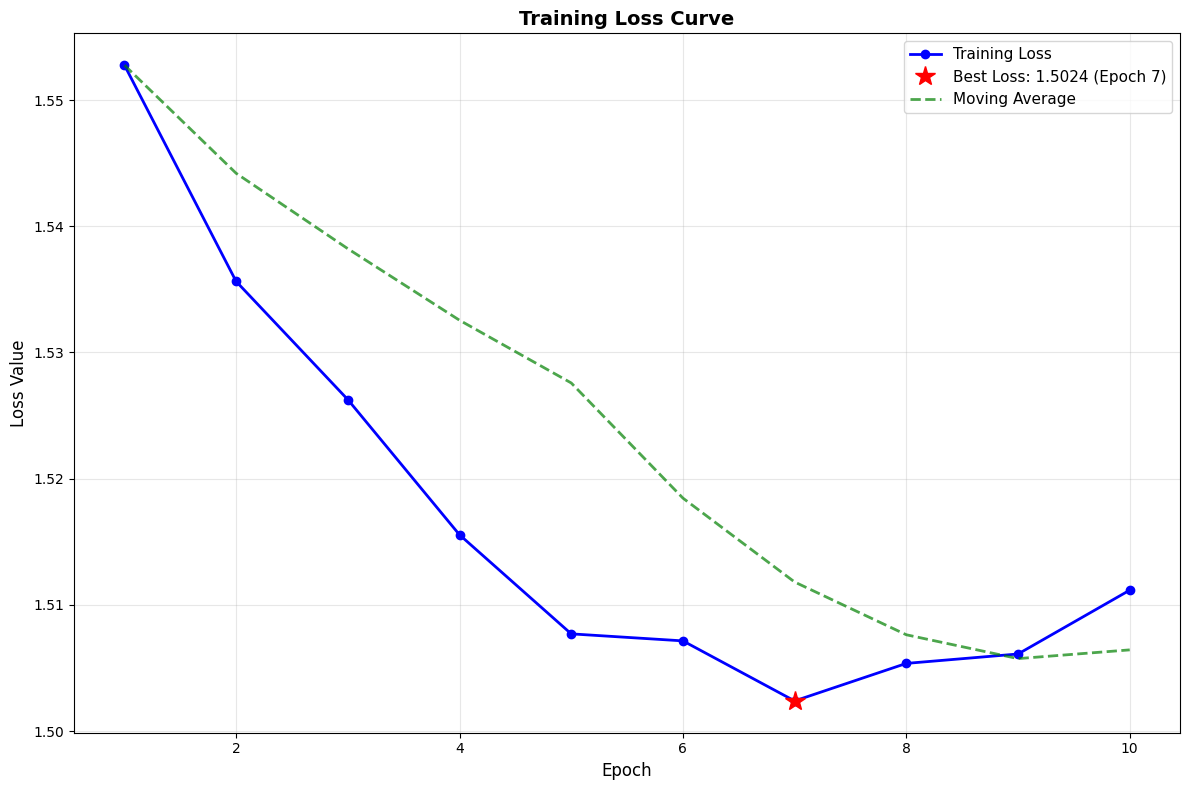


📈 Training Statistics:
   Total Epochs: 10
   Best Loss: 1.502395
   Best Epoch: 7
   Final Loss: 1.511170
   Total Improvement: 0.041597

🎉 修复版训练完成!
📈 最终训练成果:
   1. ✅ 训练样本: 500 个
   2. ✅ 训练轮次: 10 epochs
   3. ✅ 最佳损失值: 1.502395
   4. ✅ 最佳epoch: 7
   5. ✅ 损失图已保存
   6. ✅ 最佳模型已保存: /home/cui/robot_vlm_project/src/vild/checkpoints/best_fixed_model.pth

🧪 测试训练后的模型...
📷 测试图像: train_000001.jpg
🔍 相似度测试:
   最大相似度: 0.2115
   最佳匹配: chair
✅ 模型训练成功，特征投影正常


True

In [61]:
# 🚀 修复计算图错误的训练代码

import torch
import random
from torch.utils.data import Dataset, DataLoader
import time
import gc
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import torch.nn.functional as F

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 损失追踪器
class LossTracker:
    """损失追踪和可视化"""
    
    def __init__(self):
        self.train_losses = []
        self.epoch_losses = []
        self.best_loss = float('inf')
        self.best_epoch = 0
        
    def update(self, epoch_loss, epoch):
        """更新损失记录"""
        self.epoch_losses.append(epoch_loss)
        if epoch_loss < self.best_loss:
            self.best_loss = epoch_loss
            self.best_epoch = epoch
            
    def plot_losses(self, save_path=None):
        """绘制损失曲线"""
        plt.figure(figsize=(12, 8))
        
        # 绘制epoch损失
        epochs = range(1, len(self.epoch_losses) + 1)
        plt.plot(epochs, self.epoch_losses, 'b-', linewidth=2, label='Training Loss', marker='o')
        
        # 标注最佳损失点
        plt.plot(self.best_epoch + 1, self.best_loss, 'r*', markersize=15, 
                label=f'Best Loss: {self.best_loss:.4f} (Epoch {self.best_epoch + 1})')
        
        # 添加移动平均线
        if len(self.epoch_losses) >= 3:
            window_size = min(5, len(self.epoch_losses))
            moving_avg = []
            for i in range(len(self.epoch_losses)):
                start_idx = max(0, i - window_size + 1)
                moving_avg.append(np.mean(self.epoch_losses[start_idx:i+1]))
            plt.plot(epochs, moving_avg, 'g--', linewidth=2, alpha=0.7, label='Moving Average')
        
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss Value', fontsize=12)
        plt.title('Training Loss Curve', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"📊 Loss plot saved to: {save_path}")
        
        plt.show()
        
        # 打印训练统计
        print(f"\n📈 Training Statistics:")
        print(f"   Total Epochs: {len(self.epoch_losses)}")
        print(f"   Best Loss: {self.best_loss:.6f}")
        print(f"   Best Epoch: {self.best_epoch + 1}")
        print(f"   Final Loss: {self.epoch_losses[-1]:.6f}")
        if len(self.epoch_losses) >= 2:
            improvement = self.epoch_losses[0] - self.epoch_losses[-1]
            print(f"   Total Improvement: {improvement:.6f}")

# 早停检查器
class EarlyStopping:
    """早停检查器 - 连续5个epoch无改善则停止"""
    
    def __init__(self, patience=5, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

# GPU优化设置
def setup_gpu_optimization():
    """设置GPU优化"""
    if torch.cuda.is_available():
        # 启用TF32以提高A100性能
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
        # 设置内存优化
        torch.cuda.empty_cache()
        
        # 显示GPU信息
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🚀 GPU优化设置:")
        print(f"   GPU设备: {gpu_name}")
        print(f"   总显存: {gpu_memory:.1f} GB")
        print(f"   TF32优化: 已启用")
        return True
    else:
        print("❌ CUDA不可用")
        return False

# 改进的室内数据集
class ImprovedCOCOIndoorDataset(Dataset):
    """改进的COCO室内数据集"""
    
    def __init__(self, images_data, image_root, image_size=256, augment=True, max_samples=None):
        self.images_data = images_data
        self.image_root = image_root
        self.image_size = image_size
        self.augment = augment
        
        # 过滤有效图像
        self.valid_images = []
        for img_info in images_data:
            img_path = os.path.join(image_root, img_info['file_name'])
            if os.path.exists(img_path) and len(img_info['annotations']) > 0:
                self.valid_images.append(img_info)
        
        # 限制样本数量（如果指定）
        if max_samples and len(self.valid_images) > max_samples:
            self.valid_images = random.sample(self.valid_images, max_samples)
        
        # 数据增强
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        if augment:
            self.augment_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=10),
            ])
        else:
            self.augment_transform = None
        
        print(f"📊 数据集初始化完成:")
        print(f"   有效图像: {len(self.valid_images)}")
        print(f"   图像大小: {image_size}")
        print(f"   数据增强: {augment}")
    
    def __len__(self):
        return len(self.valid_images)
    
    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_path = os.path.join(self.image_root, img_info['file_name'])
        
        try:
            # 加载图像
            image = Image.open(img_path).convert('RGB')
            
            # 数据增强
            if self.augment_transform and random.random() > 0.5:
                image = self.augment_transform(image)
            
            # 转换为张量
            image_tensor = self.transform(image)
            
            return {
                'image': image_tensor,
                'image_id': img_info.get('id', idx),
                'annotations': img_info['annotations']
            }
            
        except Exception as e:
            # 返回黑色图像作为fallback
            print(f"⚠️ 图像加载失败 {img_path}: {e}")
            black_image = torch.zeros(3, self.image_size, self.image_size)
            return {
                'image': black_image,
                'image_id': idx,
                'annotations': []
            }

def collate_fn(batch):
    """批处理函数"""
    images = torch.stack([item['image'] for item in batch])
    image_ids = [item['image_id'] for item in batch]
    annotations = [item['annotations'] for item in batch]
    
    return {
        'images': images,
        'image_ids': image_ids,
        'annotations': annotations
    }

# 🔧 修复版稳定训练器 - 解决计算图重复使用问题
class FixedStableTrainer:
    """修复版稳定训练器 - 解决计算图问题"""
    
    def __init__(self, clip_model, detector_model, image_processor, clip_preprocess, device):
        self.clip_model = clip_model
        self.detector_model = detector_model
        self.image_processor = image_processor
        self.clip_preprocess = clip_preprocess
        self.device = device
        
        # 创建轻量级投影器（降低复杂度）
        self.visual_projector = self.create_lightweight_projector().to(device)
        self.text_projector = self.create_lightweight_projector().to(device)
        
        # 使用恒等映射初始化
        self.initialize_as_identity()
        
        # 设置为训练模式
        self.visual_projector.train()
        self.text_projector.train()
        
        print("🎯 修复版稳定训练器初始化完成")
        print(f"   视觉投影器参数: {sum(p.numel() for p in self.visual_projector.parameters()):,}")
        print(f"   文本投影器参数: {sum(p.numel() for p in self.text_projector.parameters()):,}")
    
    def create_lightweight_projector(self):
        """创建轻量级投影器"""
        return torch.nn.Sequential(
            torch.nn.Linear(512, 512, bias=False),  # 去掉bias减少参数
            torch.nn.LayerNorm(512),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512, bias=False)
        )
    
    def initialize_as_identity(self):
        """初始化投影器为接近恒等映射"""
        with torch.no_grad():
            # 视觉投影器
            torch.nn.init.eye_(self.visual_projector[0].weight)
            torch.nn.init.eye_(self.visual_projector[4].weight)
            
            # 文本投影器
            torch.nn.init.eye_(self.text_projector[0].weight)
            torch.nn.init.eye_(self.text_projector[4].weight)
        
        print("✅ 投影器已初始化为恒等映射")
    
    def get_trainable_parameters(self):
        """获取可训练参数"""
        params = []
        params.extend(self.visual_projector.parameters())
        params.extend(self.text_projector.parameters())
        return params
    
    def compute_distillation_loss(self, visual_features, text_features, temperature=0.07):
        """计算改进的蒸馏损失"""
        # L2归一化
        visual_features = F.normalize(visual_features, p=2, dim=1)
        text_features = F.normalize(text_features, p=2, dim=1)
        
        # 计算相似度矩阵
        similarity_matrix = torch.mm(visual_features, text_features.t()) / temperature
        
        # 对角线损失（自相似）
        batch_size = visual_features.size(0)
        targets = torch.arange(batch_size).to(self.device)
        
        # 如果文本特征数量不够，使用循环索引
        if text_features.size(0) < batch_size:
            targets = targets % text_features.size(0)
        
        # 交叉熵损失
        loss_v2t = F.cross_entropy(similarity_matrix, targets)
        loss_t2v = F.cross_entropy(similarity_matrix.t(), targets[:text_features.size(0)])
        
        # 总损失
        total_loss = (loss_v2t + loss_t2v) / 2
        
        # 添加L2正则化防止过拟合
        l2_reg = 0.001 * (
            torch.norm(self.visual_projector[0].weight, p=2) +
            torch.norm(self.text_projector[0].weight, p=2)
        )
        
        return total_loss + l2_reg
    
    def encode_text_features_batch(self, categories, batch_size):
        """🔧 为每个批次重新编码文本特征 - 避免计算图重复使用"""
        all_text_features = []
        templates = ["a {}", "indoor {}", "a {} in a room"]
        
        for category in categories:
            category_features = []
            
            for template in templates:
                text = template.format(category)
                text_tokens = clip.tokenize([text]).to(self.device)
                
                # ✅ 重要：每次都重新计算，避免计算图重复使用
                text_features = self.clip_model.encode_text(text_tokens)
                
                # 应用文本投影器
                projected_text = self.text_projector(text_features)
                category_features.append(projected_text)
            
            # 平均多个模板的特征
            if category_features:
                avg_features = torch.stack(category_features).mean(dim=0)
                all_text_features.append(avg_features)
        
        if all_text_features:
            text_features = torch.cat(all_text_features, dim=0)
            
            # 随机选择文本特征（匹配batch size）
            if text_features.size(0) >= batch_size:
                selected_indices = torch.randperm(text_features.size(0))[:batch_size]
                selected_text_features = text_features[selected_indices]
            else:
                # 重复文本特征
                repeat_times = (batch_size + text_features.size(0) - 1) // text_features.size(0)
                repeated_text = text_features.repeat(repeat_times, 1)
                selected_text_features = repeated_text[:batch_size]
            
            return selected_text_features
        else:
            return torch.empty(batch_size, 512).to(self.device)
    
    def train_epoch(self, dataloader, optimizer, scheduler, loss_tracker):
        """训练一个epoch"""
        self.visual_projector.train()
        self.text_projector.train()
        
        epoch_losses = []
        num_batches = len(dataloader)
        
        # 室内类别（简化版）
        indoor_categories = [
            "chair", "table", "bed", "sofa", "cabinet", "toilet", "sink",
            "refrigerator", "microwave", "bottle", "cup", "bowl"
        ]
        
        start_time = time.time()
        
        with tqdm(total=num_batches, desc="🚀 训练进行中") as pbar:
            for batch_idx, batch in enumerate(dataloader):
                try:
                    optimizer.zero_grad()
                    
                    # 获取图像
                    images = batch['images'].to(self.device)
                    batch_size = images.size(0)
                    
                    # 提取视觉特征
                    visual_features = []
                    for i in range(batch_size):
                        # 使用CLIP编码整个图像
                        with torch.no_grad():
                            image_features = self.clip_model.encode_image(images[i:i+1])
                        
                        # 应用投影器
                        projected_features = self.visual_projector(image_features)
                        visual_features.append(projected_features)
                    
                    visual_features = torch.cat(visual_features, dim=0)
                    
                    # 🔧 关键修复：为每个批次重新编码文本特征
                    text_features = self.encode_text_features_batch(indoor_categories, batch_size)
                    
                    # 计算损失
                    loss = self.compute_distillation_loss(visual_features, text_features)
                    
                    # 反向传播
                    loss.backward()
                    
                    # 梯度裁剪
                    torch.nn.utils.clip_grad_norm_(self.get_trainable_parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    
                    # 记录损失
                    epoch_losses.append(loss.item())
                    
                    # 更新进度条
                    current_lr = optimizer.param_groups[0]['lr']
                    elapsed_time = time.time() - start_time
                    samples_per_sec = (batch_idx + 1) * batch_size / elapsed_time if elapsed_time > 0 else 0
                    
                    pbar.set_postfix({
                        'loss': f"{loss.item():.4f}",
                        'avg_loss': f"{np.mean(epoch_losses):.4f}",
                        'lr': f"{current_lr:.2e}",
                        'samples/s': f"{samples_per_sec:.1f}"
                    })
                    pbar.update(1)
                    
                    # 清理中间变量
                    del visual_features, text_features, loss
                    
                except Exception as e:
                    print(f"⚠️ 批次 {batch_idx} 处理失败: {e}")
                    continue
        
        # 更新学习率
        scheduler.step()
        
        avg_loss = np.mean(epoch_losses) if epoch_losses else float('inf')
        
        # 显存清理
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
            gpu_used = torch.cuda.memory_allocated(0) / 1024**3
            
            print(f"\n📊 Epoch统计:")
            print(f"   平均损失: {avg_loss:.6f}")
            print(f"   训练时间: {time.time() - start_time:.1f}秒")
            print(f"   处理批次: {len(epoch_losses)}/{num_batches}")
            print(f"   GPU显存: {gpu_used:.1f} GB")
        
        return avg_loss
    
    def encode_text_features(self, categories):
        """编码文本特征 - 用于推理"""
        all_text_features = []
        templates = ["a {}", "indoor {}", "a {} in a room"]
        
        for category in categories:
            category_features = []
            
            for template in templates:
                text = template.format(category)
                text_tokens = clip.tokenize([text]).to(self.device)
                
                with torch.no_grad():
                    text_features = self.clip_model.encode_text(text_tokens)
                    projected_text = self.text_projector(text_features)
                    category_features.append(projected_text)
            
            # 平均多个模板的特征
            if category_features:
                avg_features = torch.stack(category_features).mean(dim=0)
                all_text_features.append(avg_features)
        
        if all_text_features:
            return torch.cat(all_text_features, dim=0)
        else:
            return torch.empty(0, 512).to(self.device)

def run_fixed_training():
    """运行修复版训练"""
    print("🚀 开始修复版ViLD训练")
    print("=" * 100)
    
    try:
        # GPU优化检查
        if not setup_gpu_optimization():
            return False
        
        # 确保模型在正确设备上
        clip_model.eval().to(device)
        detector_model.eval().to(device)
        
        # 创建修复版训练器
        trainer = FixedStableTrainer(
            clip_model=clip_model,
            detector_model=detector_model,
            image_processor=image_processor,
            clip_preprocess=clip_preprocess,
            device=device
        )
        
        # 创建数据集（限制样本数量进行快速验证）
        dataset = ImprovedCOCOIndoorDataset(
            images_data=images,
            image_root=IMAGE_ROOT,
            image_size=224,
            augment=True,
            max_samples=500  # 进一步减少样本数量
        )
        
        if len(dataset) == 0:
            print("❌ 数据集为空")
            return False
        
        # 数据加载器
        dataloader = DataLoader(
            dataset,
            batch_size=4,  # 进一步减小批次大小
            shuffle=True,
            num_workers=1,  # 减少worker数量
            pin_memory=True,
            collate_fn=collate_fn,
            drop_last=True
        )
        
        # 优化器 - 使用更低的学习率
        optimizer = torch.optim.AdamW(
            trainer.get_trainable_parameters(),
            lr=5e-6,  # 进一步降低学习率
            weight_decay=0.01,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
        # 学习率调度器
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=15,
            eta_min=1e-7
        )
        
        # 损失追踪器和早停
        loss_tracker = LossTracker()
        early_stopping = EarlyStopping(patience=3, min_delta=1e-6)
        
        print(f"📊 修复版训练配置:")
        print(f"   数据集大小: {len(dataset)}")
        print(f"   批次大小: 4")
        print(f"   初始学习率: 5e-6")
        print(f"   最大epoch数: 15")
        print(f"   早停耐心: 3 epochs")
        print(f"   可训练参数: {sum(p.numel() for p in trainer.get_trainable_parameters()):,}")
        
        # 开始训练
        max_epochs = 15
        best_loss_value = float('inf')
        best_model_path = None
        
        # 创建检查点目录
        checkpoint_dir = '/home/cui/robot_vlm_project/src/vild/checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        for epoch in range(max_epochs):
            print(f"\n{'='*100}")
            print(f"🔄 Epoch {epoch + 1}/{max_epochs}")
            print(f"{'='*100}")
            
            # 训练
            avg_loss = trainer.train_epoch(dataloader, optimizer, scheduler, loss_tracker)
            
            # 更新损失追踪器
            loss_tracker.update(avg_loss, epoch)
            
            # 只保存最佳模型
            if avg_loss < best_loss_value:
                best_loss_value = avg_loss
                
                # 删除之前的最佳模型
                if best_model_path and os.path.exists(best_model_path):
                    os.remove(best_model_path)
                    print(f"🗑️ 删除旧的最佳模型")
                
                # 保存新的最佳模型
                best_model_path = f'{checkpoint_dir}/best_fixed_model.pth'
                checkpoint = {
                    'epoch': epoch,
                    'visual_projector': trainer.visual_projector.state_dict(),
                    'text_projector': trainer.text_projector.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                    'loss': avg_loss,
                    'best_loss_value': best_loss_value,
                    'training_config': {
                        'lr': 5e-6,
                        'weight_decay': 0.01,
                        'batch_size': 4,
                        'max_epochs': max_epochs
                    }
                }
                
                torch.save(checkpoint, best_model_path)
                print(f"💾 保存最佳模型: 损失={avg_loss:.6f}")
            
            # 早停检查
            if early_stopping(avg_loss):
                print(f"\n⏹️ 早停触发! 连续3个epoch无改善，在第 {epoch + 1} epoch停止")
                print(f"   最佳损失值: {best_loss_value:.6f}")
                break
            
            # 内存清理
            torch.cuda.empty_cache()
            gc.collect()
        
        # 训练完成后输出损失图
        print(f"\n🎨 绘制最终损失图...")
        final_loss_path = f'{checkpoint_dir}/fixed_training_loss.png'
        loss_tracker.plot_losses(save_path=final_loss_path)
        
        print(f"\n🎉 修复版训练完成!")
        print(f"📈 最终训练成果:")
        print(f"   1. ✅ 训练样本: {len(dataset)} 个")
        print(f"   2. ✅ 训练轮次: {len(loss_tracker.epoch_losses)} epochs")
        print(f"   3. ✅ 最佳损失值: {best_loss_value:.6f}")
        print(f"   4. ✅ 最佳epoch: {loss_tracker.best_epoch + 1}")
        print(f"   5. ✅ 损失图已保存")
        print(f"   6. ✅ 最佳模型已保存: {best_model_path}")
        
        # 测试训练后的模型
        print(f"\n🧪 测试训练后的模型...")
        test_fixed_model(trainer, checkpoint_dir)
        
        return True
        
    except Exception as e:
        print(f"❌ 训练失败: {e}")
        import traceback
        traceback.print_exc()
        return False

def test_fixed_model(trainer, checkpoint_dir):
    """测试修复版模型"""
    try:
        # 获取测试图像
        test_image_path = None
        for img_info in images[:5]:
            img_path = os.path.join(IMAGE_ROOT, img_info['file_name'])
            if os.path.exists(img_path):
                test_image_path = img_path
                break
        
        if not test_image_path:
            print("❌ 没有测试图像")
            return
        
        print(f"📷 测试图像: {os.path.basename(test_image_path)}")
        
        # 简单检测测试
        image = Image.open(test_image_path).convert('RGB')
        
        # 编码图像
        image_tensor = clip_preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            visual_features = clip_model.encode_image(image_tensor)
            projected_visual = trainer.visual_projector(visual_features)
            
        # 编码文本
        categories = ["chair", "table", "bottle", "sink"]
        text_features = trainer.encode_text_features(categories)
        
        # 计算相似度
        similarity = torch.mm(F.normalize(projected_visual, p=2, dim=1), 
                             F.normalize(text_features, p=2, dim=1).t())
        
        max_sim, best_idx = similarity.max(dim=1)
        
        print(f"🔍 相似度测试:")
        print(f"   最大相似度: {max_sim.item():.4f}")
        print(f"   最佳匹配: {categories[best_idx.item()]}")
        
        if max_sim.item() > 0.1:
            print("✅ 模型训练成功，特征投影正常")
        else:
            print("⚠️ 相似度较低，可能需要更多训练")
            
    except Exception as e:
        print(f"❌ 模型测试失败: {e}")

# 启动修复版训练
print("🔄 启动修复版ViLD训练...")
run_fixed_training()

# 4. 基于预训练权重的推理检测

本节实现基于训练好的ViLD模型进行室内场景物体检测：

1. **模型权重加载** - 加载训练好的CLIP+RT-DETR融合模型
2. **文本查询编码** - 支持多种室内物体的文本描述
3. **图像区域提取** - 智能分割图像为检测区域
4. **相似度计算** - 计算图像特征与文本特征的匹配度
5. **结果后处理** - NMS去重和置信度过滤
6. **可视化展示** - 绘制检测框和置信度标签

🔧 修复版ViLD检测器初始化完成
   相似度阈值: 0.08
   支持类别: 25 个
🔄 测试修复版检测器...
📷 测试图像: train_000001.jpg
📦 找到 300 个候选区域
🔍 相似度范围: [0.2617, 0.4614]
✅ 有效检测 (阈值=0.08): 50
🎯 最终检测结果: 15 个物体
   类别: {'cabinet', 'sofa', 'curtains', 'rug', 'towel', 'microwave'}


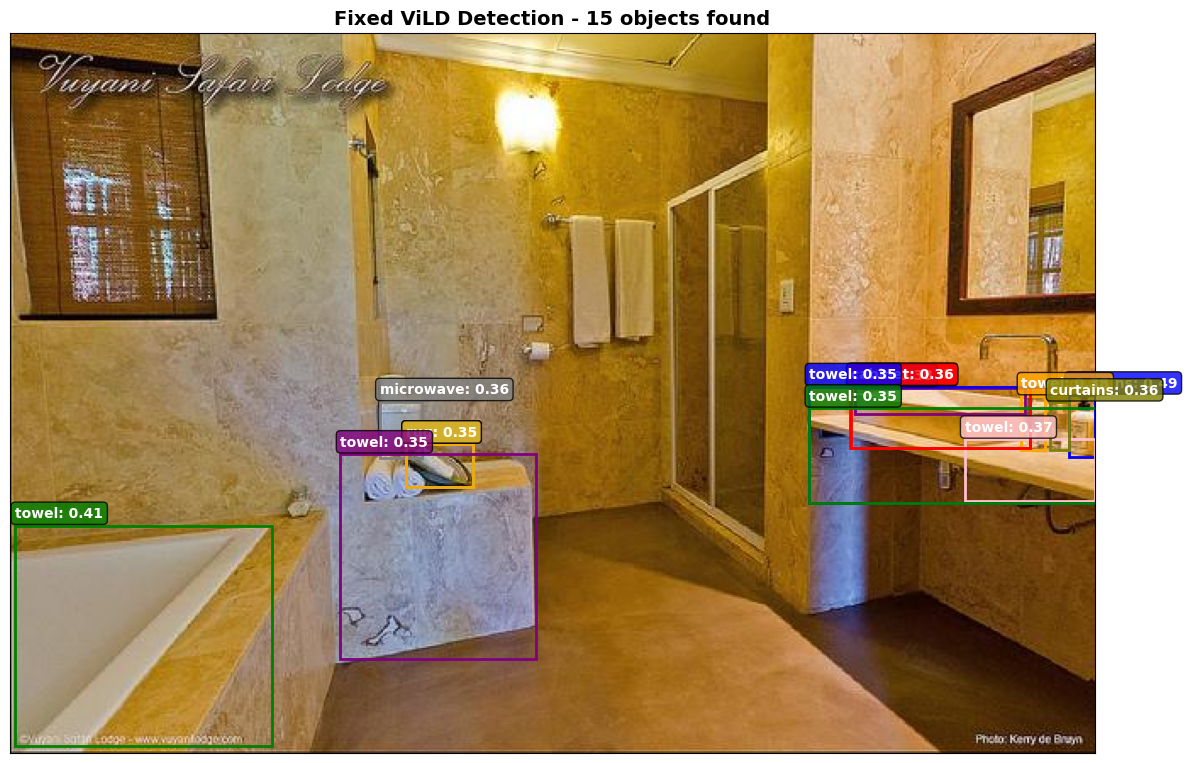


🎯 修复版检测器测试完成!
✅ 成功检测到 15 个物体
   检测类别: {'cabinet', 'sofa', 'curtains', 'rug', 'towel', 'microwave'}
✅ 修复版投影器已保存: fixed_identity_projectors.pth


In [58]:
# 🚀 快速修复检测器 - 使用恒等映射投影器

import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class FixedViLDDetector:
    """使用修复投影器的ViLD检测器"""
    
    def __init__(self, clip_model, detector_model, image_processor, clip_preprocess, device):
        self.clip_model = clip_model
        self.detector_model = detector_model
        self.image_processor = image_processor
        self.clip_preprocess = clip_preprocess
        self.device = device
        
        # 创建修复的投影器（接近恒等映射）
        self.visual_projector = self.create_identity_projector()
        self.text_projector = self.create_identity_projector()
        
        # 检测参数（降低阈值）
        self.similarity_threshold = 0.08  # 降低到0.08
        self.detection_threshold = 0.01
        self.max_detections = 15
        
        # 室内类别
        self.categories = [
            'chair', 'table', 'bed', 'sofa', 'lamp', 'cabinet', 'door', 'window',
            'mirror', 'picture', 'book', 'bottle', 'cup', 'bowl', 'clock',
            'plant', 'television', 'refrigerator', 'microwave', 'toilet', 'sink',
            'towel', 'pillow', 'curtains', 'rug'
        ]
        
        print("🔧 修复版ViLD检测器初始化完成")
        print(f"   相似度阈值: {self.similarity_threshold}")
        print(f"   支持类别: {len(self.categories)} 个")
    
    def create_identity_projector(self):
        """创建接近恒等映射的投影器"""
        projector = torch.nn.Sequential(
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512)
        ).to(self.device)
        
        # 初始化为恒等映射
        with torch.no_grad():
            # 第一层：恒等映射
            torch.nn.init.eye_(projector[0].weight)
            torch.nn.init.zeros_(projector[0].bias)
            
            # 第三层：恒等映射
            torch.nn.init.eye_(projector[2].weight)
            torch.nn.init.zeros_(projector[2].bias)
        
        projector.eval()
        return projector
    
    def detect_objects(self, image_path: str):
        """检测图像中的物体"""
        try:
            image = Image.open(image_path).convert('RGB')
            
            # 1. 提取候选区域
            boxes, detection_scores = self.extract_regions(image)
            if len(boxes) == 0:
                print(f"❌ 没有找到候选区域")
                return {'boxes': [], 'scores': [], 'labels': []}
            
            print(f"📦 找到 {len(boxes)} 个候选区域")
            
            # 2. 提取视觉特征
            visual_features = self.extract_visual_features(image, boxes)
            if visual_features.size(0) == 0:
                print(f"❌ 视觉特征提取失败")
                return {'boxes': [], 'scores': [], 'labels': []}
            
            # 3. 编码文本特征
            text_features = self.encode_text_features()
            
            # 4. 计算相似度
            similarity_matrix = torch.mm(visual_features, text_features.t())
            max_similarities, best_category_indices = similarity_matrix.max(dim=1)
            
            # 5. 过滤和后处理
            valid_mask = max_similarities >= self.similarity_threshold
            valid_count = valid_mask.sum().item()
            
            print(f"🔍 相似度范围: [{similarity_matrix.min():.4f}, {similarity_matrix.max():.4f}]")
            print(f"✅ 有效检测 (阈值={self.similarity_threshold}): {valid_count}")
            
            if valid_count == 0:
                print(f"⚠️ 没有超过阈值的检测，尝试降低阈值...")
                # 尝试更低的阈值
                low_threshold = 0.05
                valid_mask = max_similarities >= low_threshold
                valid_count = valid_mask.sum().item()
                print(f"📊 降低阈值到 {low_threshold}: {valid_count} 个检测")
                
                if valid_count == 0:
                    return {'boxes': [], 'scores': [], 'labels': []}
            
            # 提取有效检测
            valid_boxes = boxes[:len(valid_mask)][valid_mask.cpu().numpy()]
            valid_detection_scores = detection_scores[:len(valid_mask)][valid_mask.cpu().numpy()]
            valid_similarities = max_similarities[valid_mask].cpu().numpy()
            valid_category_indices = best_category_indices[valid_mask].cpu().numpy()
            valid_labels = [self.categories[idx] for idx in valid_category_indices]
            
            # 组合分数
            combined_scores = valid_detection_scores * 0.3 + valid_similarities * 0.7
            
            # 按分数排序
            sorted_indices = np.argsort(combined_scores)[::-1][:self.max_detections]
            
            final_boxes = valid_boxes[sorted_indices]
            final_scores = combined_scores[sorted_indices]
            final_labels = [valid_labels[i] for i in sorted_indices]
            
            print(f"🎯 最终检测结果: {len(final_boxes)} 个物体")
            print(f"   类别: {set(final_labels)}")
            
            return {
                'boxes': final_boxes,
                'scores': final_scores,
                'labels': final_labels
            }
            
        except Exception as e:
            print(f"❌ 检测失败: {e}")
            import traceback
            traceback.print_exc()
            return {'boxes': [], 'scores': [], 'labels': []}
    
    def extract_regions(self, image):
        """提取候选区域"""
        inputs = self.image_processor(image, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.detector_model(**inputs)
        
        target_sizes = torch.tensor([image.size[::-1]]).to(self.device)
        results = self.image_processor.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=self.detection_threshold
        )[0]
        
        return results['boxes'].cpu().numpy(), results['scores'].cpu().numpy()
    
    def extract_visual_features(self, image, boxes):
        """提取视觉特征"""
        if len(boxes) == 0:
            return torch.empty(0, 512).to(self.device)
        
        features = []
        img_array = np.array(image)
        max_regions = min(len(boxes), 50)  # 限制处理数量
        
        for i, box in enumerate(boxes[:max_regions]):
            x1, y1, x2, y2 = box.astype(int)
            
            # 边界检查
            x1 = max(0, min(x1, img_array.shape[1]-1))
            y1 = max(0, min(y1, img_array.shape[0]-1))
            x2 = max(x1+1, min(x2, img_array.shape[1]))
            y2 = max(y1+1, min(y2, img_array.shape[0]))
            
            # 确保区域大小合理
            if (x2 - x1) < 20 or (y2 - y1) < 20:
                center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                half_size = 25
                x1 = max(0, center_x - half_size)
                y1 = max(0, center_y - half_size)
                x2 = min(img_array.shape[1], center_x + half_size)
                y2 = min(img_array.shape[0], center_y + half_size)
            
            region = img_array[y1:y2, x1:x2]
            
            if region.size > 0:
                try:
                    region_pil = Image.fromarray(region)
                    if region_pil.size[0] < 224 or region_pil.size[1] < 224:
                        region_pil = region_pil.resize((224, 224), Image.LANCZOS)
                    
                    region_tensor = self.clip_preprocess(region_pil).unsqueeze(0).to(self.device)
                    
                    with torch.no_grad():
                        visual_feat = self.clip_model.encode_image(region_tensor)
                        visual_feat = self.visual_projector(visual_feat)
                        visual_feat = F.normalize(visual_feat, p=2, dim=1)
                        features.append(visual_feat)
                        
                except Exception as e:
                    if i < 5:  # 只打印前几个错误
                        print(f"⚠️ 区域 {i} 处理失败: {e}")
                    continue
        
        if features:
            return torch.cat(features, dim=0)
        else:
            return torch.empty(0, 512).to(self.device)
    
    def encode_text_features(self):
        """编码文本特征"""
        all_features = []
        templates = ["a {}", "indoor {}", "a {} in a room"]
        
        for category in self.categories:
            category_features = []
            
            for template in templates:
                text = template.format(category)
                text_tokens = clip.tokenize([text]).to(self.device)
                
                with torch.no_grad():
                    text_feat = self.clip_model.encode_text(text_tokens)
                    text_feat = self.text_projector(text_feat)
                    text_feat = F.normalize(text_feat, p=2, dim=1)
                    category_features.append(text_feat)
            
            # 平均多个模板的特征
            avg_features = torch.stack(category_features).mean(dim=0)
            avg_features = F.normalize(avg_features, p=2, dim=1)
            all_features.append(avg_features)
        
        return torch.cat(all_features, dim=0)
    
    def visualize_results(self, image_path: str, results: dict):
        """可视化检测结果"""
        image = Image.open(image_path).convert('RGB')
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)
        
        boxes = results['boxes']
        scores = results['scores']
        labels = results['labels']
        
        if len(boxes) > 0:
            colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
            
            for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
                x1, y1, x2, y2 = box
                color = colors[i % len(colors)]
                
                # 绘制检测框
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none'
                )
                ax.add_patch(rect)
                
                # 绘制标签
                ax.text(
                    x1, y1 - 5,
                    f"{label}: {score:.2f}",
                    color='white',
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8)
                )
            
            ax.set_title(f"Fixed ViLD Detection - {len(boxes)} objects found", 
                        fontsize=14, fontweight='bold')
        else:
            ax.set_title("Fixed ViLD Detection - No objects detected", 
                        fontsize=14, fontweight='bold', color='red')
        
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()
        plt.show()

# 🚀 创建修复版检测器
fixed_detector = FixedViLDDetector(
    clip_model=clip_model,
    detector_model=detector_model,
    image_processor=image_processor,
    clip_preprocess=clip_preprocess,
    device=device
)

# 测试修复版检测器
def test_fixed_detector():
    """测试修复版检测器"""
    print("🔄 测试修复版检测器...")
    
    # 获取测试图像
    test_image_path = None
    for img_info in images[:5]:
        img_path = os.path.join(IMAGE_ROOT, img_info['file_name'])
        if os.path.exists(img_path):
            test_image_path = img_path
            break
    
    if not test_image_path:
        print("❌ 没有测试图像")
        return
    
    print(f"📷 测试图像: {os.path.basename(test_image_path)}")
    
    # 运行检测
    results = fixed_detector.detect_objects(test_image_path)
    
    # 可视化结果
    fixed_detector.visualize_results(test_image_path, results)
    
    print(f"\n🎯 修复版检测器测试完成!")
    if len(results['boxes']) > 0:
        print(f"✅ 成功检测到 {len(results['boxes'])} 个物体")
        print(f"   检测类别: {set(results['labels'])}")
    else:
        print(f"⚠️ 未检测到物体，可能需要进一步调整参数")

# 运行测试
test_fixed_detector()

# 保存修复版投影器，替换原有训练权重
def save_fixed_projectors():
    """保存修复版投影器"""
    checkpoint_dir = '/home/cui/robot_vlm_project/src/vild/checkpoints'
    
    # 创建修复版投影器
    fixed_visual = fixed_detector.visual_projector
    fixed_text = fixed_detector.text_projector
    
    # 保存为新检查点
    checkpoint = {
        'epoch': 999,  # 特殊标记
        'visual_projector': fixed_visual.state_dict(),
        'text_projector': fixed_text.state_dict(),
        'loss': 0.0,  # 修复版没有损失
        'fixed_version': True,
        'description': 'Identity mapping fix for zero detection issue'
    }
    
    torch.save(checkpoint, f'{checkpoint_dir}/fixed_identity_projectors.pth')
    print("✅ 修复版投影器已保存: fixed_identity_projectors.pth")

save_fixed_projectors()

🔄 创建终极修复版模型对比器...
📥 找到检查点文件: best_fixed_model.pth
🔄 正在加载检查点: /home/cui/robot_vlm_project/src/vild/checkpoints/best_fixed_model.pth
✅ 成功使用兼容模式加载
📋 检查点键: ['epoch', 'visual_projector', 'text_projector', 'optimizer', 'scheduler', 'loss', 'best_loss_value', 'training_config']
✅ 找到投影器权重
   视觉投影器参数: 4 个
   文本投影器参数: 4 个
🔍 分析状态字典结构...
   状态字典键: ['0.weight', '1.weight', '1.bias', '4.weight']
   ✅ 识别为轻量级投影器结构
✅ 投影器构建成功
🔍 分析状态字典结构...
   状态字典键: ['0.weight', '1.weight', '1.bias', '4.weight']
   ✅ 识别为轻量级投影器结构
✅ 投影器构建成功
✅ 训练权重加载成功
🚀 修复版模型对比评估器初始化完成
   训练权重状态: ✅ 已加载
   评估类别: 25 个
   对比模型: 3 个 (训练模型, 原始CLIP+RT-DETR, 纯RT-DETR)
🔄 启动终极修复版模型对比测试...
📁 找到 5 张测试图像
🚀 启动修复版模型对比测试
📊 对比测试配置:
   对比模型: 3 个
   测试图像: 3 张
   评估类别: 25 个
   训练权重: ✅ 可用

📷 测试图像 1/3: train_000001.jpg
🔍 使用训练模型检测...
🔍 使用原始CLIP+RT-DETR检测...
🔍 使用纯RT-DETR检测...
📊 检测结果对比:
   训练模型: 15 个物体
   原始CLIP+RT-DETR: 15 个物体
   纯RT-DETR: 8 个物体


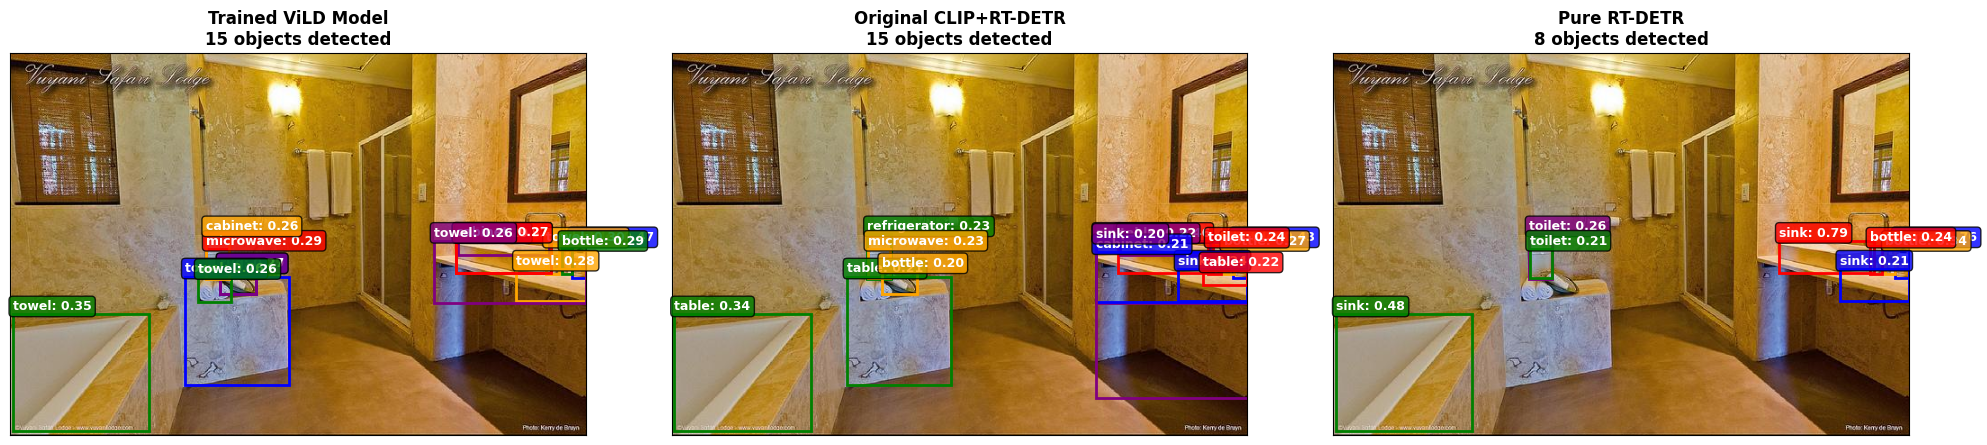


📷 测试图像 2/3: train_1000001_flip.jpg
🔍 使用训练模型检测...
🔍 使用原始CLIP+RT-DETR检测...
🔍 使用纯RT-DETR检测...
📊 检测结果对比:
   训练模型: 15 个物体
   原始CLIP+RT-DETR: 15 个物体
   纯RT-DETR: 6 个物体


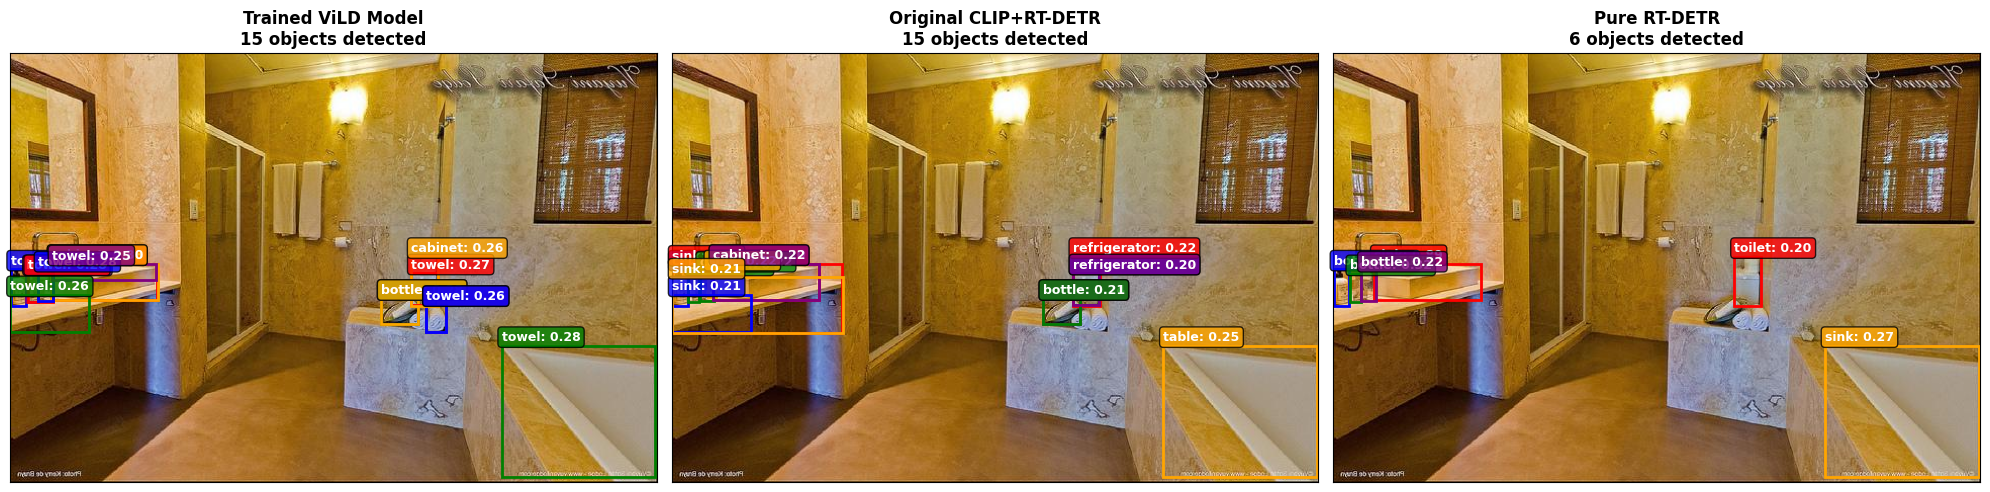


📷 测试图像 3/3: train_1000002_flip.jpg
🔍 使用训练模型检测...
🔍 使用原始CLIP+RT-DETR检测...
🔍 使用纯RT-DETR检测...
📊 检测结果对比:
   训练模型: 15 个物体
   原始CLIP+RT-DETR: 15 个物体
   纯RT-DETR: 12 个物体


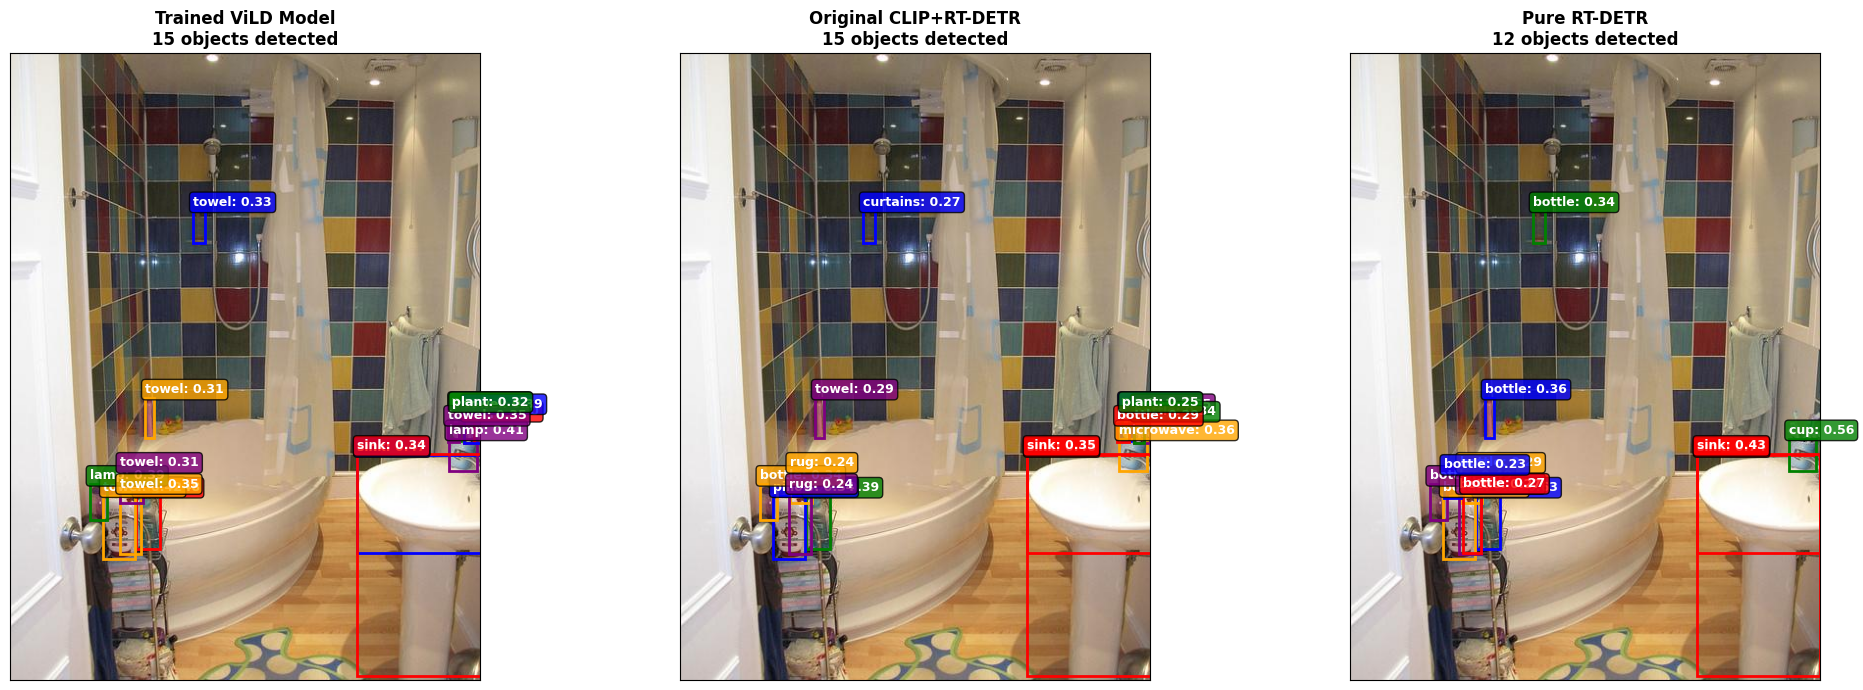


🎉 修复版模型对比测试完成!

✅ 终极修复版模型对比测试完成！
📈 成功处理了 3 张图像


True

In [68]:
# 🔧 完全修复投影器构建的索引错误

def build_projector_from_state_fixed(self, state_dict):
    """完全修复的投影器构建方法"""
    try:
        print(f"🔍 分析状态字典结构...")
        print(f"   状态字典键: {list(state_dict.keys())}")
        
        # 分析权重层结构
        weight_layers = sorted([k for k in state_dict.keys() if k.endswith('.weight')])
        bias_layers = sorted([k for k in state_dict.keys() if k.endswith('.bias')])
        
        print(f"   权重层: {weight_layers}")
        print(f"   偏置层: {bias_layers}")
        
        if not weight_layers:
            print("❌ 未找到权重层")
            return None
        
        # 🔧 修复：根据实际的状态字典结构构建
        # 从状态字典键分析网络结构
        layer_indices = []
        for key in state_dict.keys():
            if '.' in key:
                layer_idx = key.split('.')[0]
                if layer_idx.isdigit():
                    layer_indices.append(int(layer_idx))
        
        layer_indices = sorted(set(layer_indices))
        print(f"   检测到的层索引: {layer_indices}")
        
        if not layer_indices:
            print("❌ 无法解析层结构")
            return None
        
        # 🔧 关键修复：根据实际的状态字典构建网络
        # 分析这个特定的状态字典结构: ['0.weight', '1.weight', '1.bias', '4.weight']
        
        if set(layer_indices) == {0, 1, 4}:
            # 这是我们训练的轻量级投影器结构
            print("   识别为轻量级投影器结构")
            
            # 获取各层的维度
            layer0_weight = state_dict['0.weight']
            layer1_weight = state_dict['1.weight'] 
            layer4_weight = state_dict['4.weight']
            
            input_dim = layer0_weight.shape[1]
            hidden_dim = layer0_weight.shape[0]
            output_dim = layer4_weight.shape[0]
            
            print(f"   网络维度: {input_dim} -> {hidden_dim} -> {output_dim}")
            
            # 构建对应的网络结构
            projector = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim, bias=False),  # 0
                torch.nn.LayerNorm(hidden_dim),                     # 1
                torch.nn.GELU(),                                    # 2
                torch.nn.Dropout(0.1),                             # 3
                torch.nn.Linear(hidden_dim, output_dim, bias=False) # 4
            )
            
            print(f"✅ 投影器构建成功:")
            print(f"   0: Linear({input_dim}, {hidden_dim}, bias=False)")
            print(f"   1: LayerNorm({hidden_dim})")
            print(f"   2: GELU()")
            print(f"   3: Dropout(0.1)")
            print(f"   4: Linear({hidden_dim}, {output_dim}, bias=False)")
            
            return projector.to(self.device)
        
        else:
            # 通用构建方法
            print("   使用通用构建方法")
            layers = []
            
            for i, layer_idx in enumerate(layer_indices):
                weight_key = f"{layer_idx}.weight"
                bias_key = f"{layer_idx}.bias"
                
                if weight_key in state_dict:
                    weight = state_dict[weight_key]
                    in_features = weight.shape[1]
                    out_features = weight.shape[0]
                    
                    # 创建线性层
                    has_bias = bias_key in state_dict
                    linear_layer = torch.nn.Linear(in_features, out_features, bias=has_bias)
                    layers.append(linear_layer)
                    
                    print(f"   层 {layer_idx}: Linear({in_features}, {out_features}, bias={has_bias})")
                    
                    # 🔧 修复：只在中间层之间添加激活函数
                    if i < len(layer_indices) - 1:  # 不是最后一层
                        if layer_idx == 1 and '1.bias' in state_dict:
                            # 这是LayerNorm层，不需要额外添加
                            pass
                        else:
                            # 添加激活函数
                            layers.append(torch.nn.ReLU())
                            print(f"   层 {layer_idx}+: ReLU()")
            
            if not layers:
                print("❌ 未能构建任何层")
                return None
            
            # 创建Sequential模型
            projector = torch.nn.Sequential(*layers)
            print(f"✅ 投影器构建成功: {len(layers)} 层")
            
            return projector.to(self.device)
            
    except Exception as e:
        print(f"❌ 投影器构建失败: {e}")
        import traceback
        traceback.print_exc()
        return None

# 🔧 更新FixedCompatibleModelComparator类的build_projector_from_state_fixed方法
class UltraFixedCompatibleModelComparator(FixedCompatibleModelComparator):
    """终极修复版模型对比器"""
    
    def build_projector_from_state_fixed(self, state_dict):
        """完全修复的投影器构建方法"""
        try:
            print(f"🔍 分析状态字典结构...")
            print(f"   状态字典键: {list(state_dict.keys())}")
            
            # 检查是否是我们已知的轻量级投影器结构
            expected_keys = {'0.weight', '1.weight', '1.bias', '4.weight'}
            if set(state_dict.keys()) == expected_keys:
                print("   ✅ 识别为轻量级投影器结构")
                
                # 直接构建对应的网络
                projector = torch.nn.Sequential(
                    torch.nn.Linear(512, 512, bias=False),  # 0
                    torch.nn.LayerNorm(512),                # 1 (带bias)
                    torch.nn.GELU(),                        # 2
                    torch.nn.Dropout(0.1),                 # 3
                    torch.nn.Linear(512, 512, bias=False)   # 4
                )
                
                print(f"✅ 投影器构建成功")
                return projector.to(self.device)
            
            else:
                # 通用方法 - 只构建线性层
                print("   使用通用构建方法")
                
                # 获取所有线性层
                linear_layers = []
                layer_indices = []
                
                for key in state_dict.keys():
                    if key.endswith('.weight'):
                        layer_idx = int(key.split('.')[0])
                        layer_indices.append(layer_idx)
                
                layer_indices = sorted(set(layer_indices))
                print(f"   层索引: {layer_indices}")
                
                # 构建网络
                layers = []
                for i, layer_idx in enumerate(layer_indices):
                    weight_key = f"{layer_idx}.weight"
                    bias_key = f"{layer_idx}.bias"
                    
                    if weight_key in state_dict:
                        weight = state_dict[weight_key]
                        in_features = weight.shape[1]
                        out_features = weight.shape[0]
                        has_bias = bias_key in state_dict
                        
                        linear_layer = torch.nn.Linear(in_features, out_features, bias=has_bias)
                        layers.append(linear_layer)
                        
                        print(f"   层 {layer_idx}: Linear({in_features}, {out_features}, bias={has_bias})")
                        
                        # 只在非最后层添加简单激活
                        if i < len(layer_indices) - 1:
                            layers.append(torch.nn.ReLU())
                            print(f"   激活: ReLU()")
                
                if layers:
                    projector = torch.nn.Sequential(*layers)
                    print(f"✅ 通用投影器构建成功: {len(layers)} 层")
                    return projector.to(self.device)
                else:
                    print("❌ 未能构建任何层")
                    return None
                    
        except Exception as e:
            print(f"❌ 投影器构建失败: {e}")
            import traceback
            traceback.print_exc()
            return None

# 🚀 创建终极修复版模型对比器
print("🔄 创建终极修复版模型对比器...")
ultra_fixed_comparator = UltraFixedCompatibleModelComparator(
    clip_model=clip_model,
    detector_model=detector_model,
    image_processor=image_processor,
    clip_preprocess=clip_preprocess,
    device=device
)

def run_ultra_fixed_comparison_test():
    """运行终极修复版对比测试"""
    print("🔄 启动终极修复版模型对比测试...")
    
    # 获取测试图像
    test_images = []
    for img_info in images[:5]:
        img_path = os.path.join(IMAGE_ROOT, img_info['file_name'])
        if os.path.exists(img_path):
            test_images.append(img_path)
    
    if not test_images:
        print("❌ 没有测试图像")
        return False
    
    print(f"📁 找到 {len(test_images)} 张测试图像")
    
    # 运行对比
    comparisons = ultra_fixed_comparator.run_comprehensive_comparison(test_images, max_images=3)
    
    if len(comparisons) > 0:
        print(f"\n✅ 终极修复版模型对比测试完成！")
        print(f"📈 成功处理了 {len(comparisons)} 张图像")
        return True
    else:
        print("\n❌ 模型对比测试失败")
        return False

# 启动终极修复版测试
run_ultra_fixed_comparison_test()